### Summarize mean daily standing biomass by pasture at CPER
Uses pre-processed daily Biomass rasters from Harmonized Landsat Sentinel (HLS - see Kearney et al. 2022) and Landsat-MODIS fusion (LMF). Computes the mean of all grid cells within each pasture. Returns a .csv file with a single Biomass value for each date for each pasture.

In [1]:
import rioxarray as riox
import rasterio as rio
import xarray as xr
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from hlsstack.hls_funcs.masks import shp2mask
from tqdm import tqdm
import glob
from hlsstack.utils.hpc_setup import launch_dask
import seaborn as sns

In [2]:
# path to HLS data
prefix = 'cper'

# the paths to shapefiles with VFCH4 pasture boundaries
cper_vfch = "../../data/ground/boundaries/VFCH4_rotationPolygon.shp"

# the range of years to be processed
yrs = range(2024, 2025)
# drop 2012 since it could not be processed by LMF
yrs = [x for x in yrs if x != 2012]

hls_yrs = list(np.arange(2015, 2025))
lmf_yrs = [x for x in np.arange(2000, 2015) if x != 2012]

# the output path for the csv file
out_f = './vfch_pasture_cp_bm_2024.csv'

In [36]:
cper = gpd.read_file(cper_vfch).to_crs(32613)
cper = cper.rename(columns={'Pstr_Rt': 'Pasture'})

In [37]:
# remove the exclusion pond area
excl_pond = cper[cper['Pasture'] == '17S ExclusionPond'].copy()
cper = cper[cper['Pasture'] != '17S ExclusionPond'].copy()
cper = cper.overlay(excl_pond, how='difference')

In [38]:
cper = cper.dissolve('Pasture').reset_index()

<AxesSubplot:>

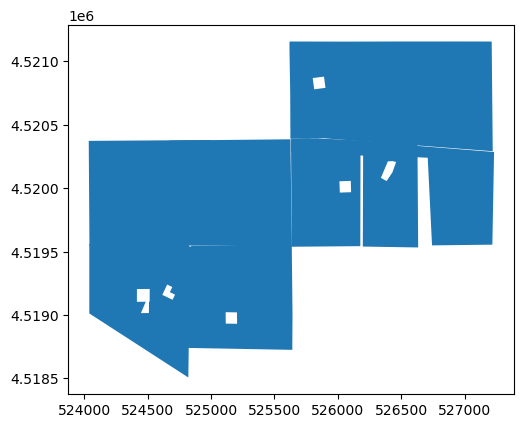

In [39]:
cper.plot()

In [40]:
cper['placeholder'] = 0

In [41]:
past17S = cper[cper['Pasture'].str.contains('17S')].dissolve('placeholder')
past17S['Pasture'] = '17S'

past18S = cper[cper['Pasture'].str.contains('18S')].dissolve('placeholder')
past18S['Pasture'] = '18S'

In [42]:
cper_extra = pd.concat([past17S, past18S])

In [43]:
# whether to overwrite all existing complete years
overwrite_complete_yrs = True

# whether to overwrite incomplete years (or simply append new data)
overwrite_incomplete_yrs = True

In [12]:
# setup the dask cluster
print('   setting up Local cluster...')
from dask.distributed import LocalCluster, Client
import dask
dask.config.set({'distributed.worker.daemon': False})
cluster = LocalCluster(n_workers=36, threads_per_worker=2)
client = Client(cluster)
display(client)

   setting up Local cluster...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 36
Total threads: 72,Total memory: 270.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39051,Workers: 36
Dashboard: http://127.0.0.1:8787/status,Total threads: 72
Started: Just now,Total memory: 270.21 GiB
Comm: tcp://127.0.0.1:40959,Total threads: 2
Dashboard: http://127.0.0.1:34873/status,Memory: 7.51 GiB
Nanny: tcp://127.0.0.1:36227,


In [44]:
# load and preprare any existing output data
if os.path.exists(out_f):
    if not overwrite_complete_yrs:
        df_out = pd.read_csv(out_f, parse_dates=['date'])
        if overwrite_incomplete_yrs:
            max_yday = df_out.groupby(df_out['Year'])['date'].max().dt.dayofyear
            drop_yrs = max_yday[max_yday < 365].index.values
            if len(drop_yrs) > 0:
                print('Dropping incomplete years:')
                print(drop_yrs)
                df_out = df_out[~df_out['Year'].isin(drop_yrs)].copy()
    else:
        df_out = None
else:
    df_out = None

In [45]:
#df_out = None

In [46]:
inDIR = '/90daydata/cper_neon_aop/hls_nrt'

In [47]:
# loop through each year and extract pasture biomass means for each date
for idx, yr in enumerate(tqdm(yrs)):
    if df_out is not None:
        if yr in df_out['Year'].unique():
            skip_yr = True
        else:
            skip_yr = False
    else:
        skip_yr = False
    if skip_yr:
        continue
    else:
        for shp in [cper, cper_extra]:
            # prepare the pasture boundaries to be converted into an xarray mask
            cper_info = shp[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
            past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
            past_dict[0] = 'UNK'
            cper_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]
            
            hls_path = os.path.join(inDIR, 'gcloud', 'hls_' + prefix + '_' + str(yr) + '_gcloud.nc')
            ds = ds = riox.open_rasterio(hls_path, masked=True)
            
            if type(ds) == xr.core.dataarray.DataArray:
                ds = ds.to_dataset()
            # reproject if necessary
            if ds.rio.crs == None:
                ds = ds.rio.write_crs(shp.crs)
            elif ds.rio.crs != shp.crs:
                ds = ds.rio.reproject(shp.crs)
            if 'band' in ds.coords:
                # convert the band coordinate to date
                ds['band'] = [datetime(yr, 1, 1) + timedelta(days=int(x)) for x in ds['band'].values]
                # rename band coordinate to date
                ds = ds.rename({'band': 'date'})
            if 'time' in ds.coords:
                # rename band coordinate to date
                ds = ds.rename({'time': 'date'})
            # create the pasture mask from shapefile
            cper_mask = shp2mask(shp=cper_mask_shp, 
                                 transform=ds.rio.transform(), 
                                 outshape=ds['Biomass'].shape[1:], 
                                 xr_object=ds['Biomass'])
            # convert from numeric id's to pasture names
            past_mask = np.array([past_dict[i] for i in cper_mask.values.flatten()]).reshape(cper_mask.shape)
            # add the pasture mask to the biomass dataset
            ds = ds.assign(Pasture=(['y', 'x'], past_mask)).chunk({'y': 50, 'x': 50})
            ds = ds.set_coords('Pasture')
            # get pasture means and convert to dataframe
            df_yr = ds.groupby(
                ds['Pasture']).mean(
                dim='stacked_y_x', skipna=True).to_dataframe().reset_index().drop(
                columns='spatial_ref')
            df_yr['Year'] = yr
            df_yr = df_yr.rename(columns={'Biomass': 'Biomass_kg_ha'})
            # add the data source to the output dataframe
            #df_yr['Source'] = dat_source
            df_yr = df_yr[df_yr['Pasture'] != 'UNK']
            # create the initial output dataframe if it doesn't exist
            if df_out is None:
                df_out = df_yr.copy()
            # append to the existing output dataframe
            else:
                df_out = pd.concat([df_out, df_yr])

100%|██████████| 1/1 [01:13<00:00, 73.80s/it]


In [48]:
df_out.Pasture.unique()

array(['17N', '17S R1', '17S R2', '17S R3', '18S R1', '18S R2', '19N',
       '17S', '18S'], dtype=object)

In [49]:
from rasterio.plot import show

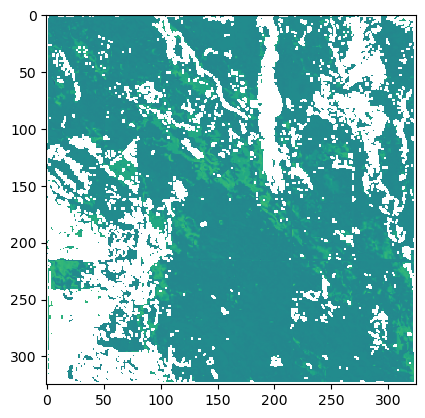

<AxesSubplot:>

In [50]:
show(ds.isel(date=100)['CP'].data, vmin=6, vmax=13)

In [51]:
df_out['date'] = pd.to_datetime(df_out['date'].apply(lambda x: x.isoformat()))

In [52]:
import seaborn as sns

In [53]:
df_out[df_out == np.inf] = np.nan

In [54]:
df_out.loc[df_out['Biomass_kg_ha'] > 10000, 'Biomass_kg_ha'] = np.nan

In [55]:
df_out.groupby('Pasture').apply(lambda x: x['CP'].isnull().sum())

Pasture
17N       54
17S       82
17S R1    88
17S R2    82
17S R3    85
18S       67
18S R1    80
18S R2    67
19N       78
dtype: int64

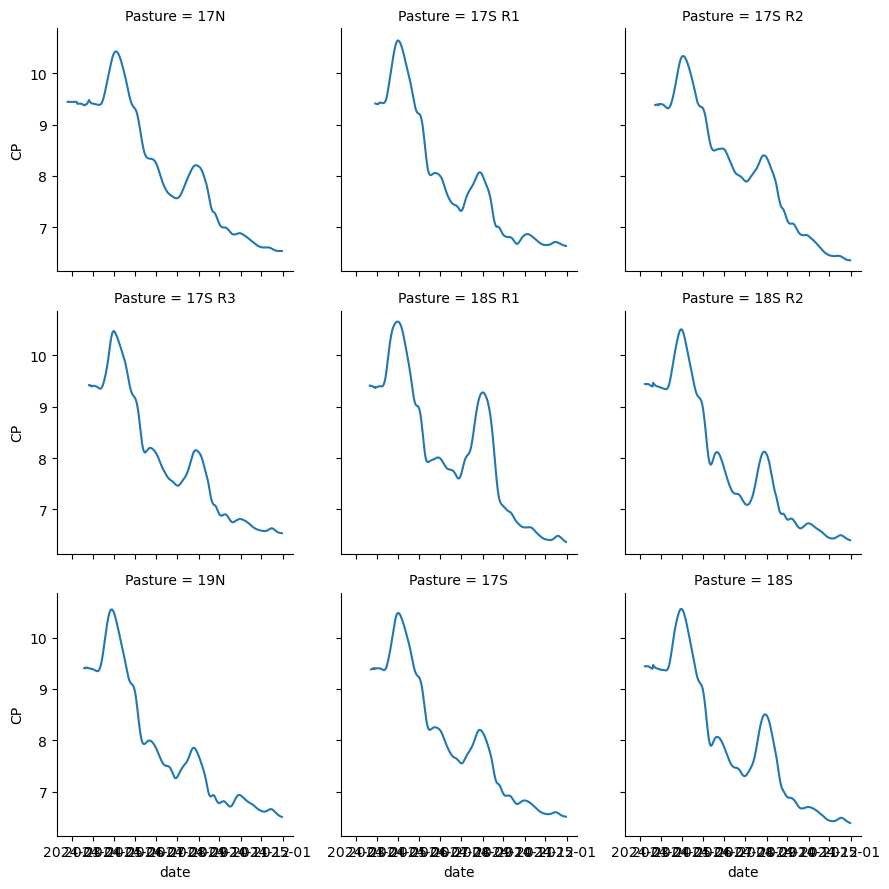

In [56]:
g = sns.FacetGrid(col='Pasture', col_wrap=3, data=df_out)
g.map_dataframe(sns.lineplot, x='date', y='CP')

In [57]:
df_out['Year'] = df_out['date'].dt.year

In [58]:
df_out.to_csv(out_f, index=False)

In [22]:
df_sub = df_out.copy()

In [23]:
#np.concatenate([pd.date_range('5-19-2024', '6-13-2024'), pd.date_range('7-12-2024', '8-8-2024')])

In [24]:
df_sub.loc[(df_sub['Pasture'] == '17N') &
 (~df_sub['date'].isin(pd.date_range('5-28-2024', '9-5-2024'))), ['Biomass_kg_ha', 'CP']] = np.nan

df_sub.loc[(df_sub['Pasture'] == '17S R1') &
 (~df_sub['date'].isin(pd.date_range('5-28-2024', '6-28-2024'))), ['Biomass_kg_ha', 'CP']] = np.nan
df_sub.loc[(df_sub['Pasture'] == '17S R2') &
 (~df_sub['date'].isin(pd.date_range('6-29-2024', '7-29-2024'))), ['Biomass_kg_ha', 'CP']] = np.nan
df_sub.loc[(df_sub['Pasture'] == '17S R3') &
 (~df_sub['date'].isin(pd.date_range('7-30-2024', '9-5-2024'))), ['Biomass_kg_ha', 'CP']] = np.nan

df_sub.loc[(df_sub['Pasture'] == '19N') &
 (~df_sub['date'].isin(pd.date_range('5-19-2024', '9-5-2024'))), ['Biomass_kg_ha', 'CP']] = np.nan

df_sub.loc[(df_sub['Pasture'] == '18S R1') &
 (~df_sub['date'].isin(np.concatenate([pd.date_range('5-19-2024', '6-13-2024'),
                                       pd.date_range('7-12-2024', '8-8-2024')]))), ['Biomass_kg_ha', 'CP']] = np.nan

df_sub.loc[(df_sub['Pasture'] == '18S R2') &
 (~df_sub['date'].isin(np.concatenate([pd.date_range('6-14-2024', '7-11-2024'),
                                       pd.date_range('8-9-2024', '9-5-2024')]))), ['Biomass_kg_ha', 'CP']] = np.nan

In [25]:
df_sub['CP_orig'] = df_out['CP']
df_sub['Biomass_kg_ha_orig'] = df_out['Biomass_kg_ha']

In [26]:
df_sub['Group'] = 0

In [27]:
df_sub.loc[df_sub['Pasture'].str.contains('17'), 'Group'] = 1

In [28]:
import matplotlib.pyplot as plt

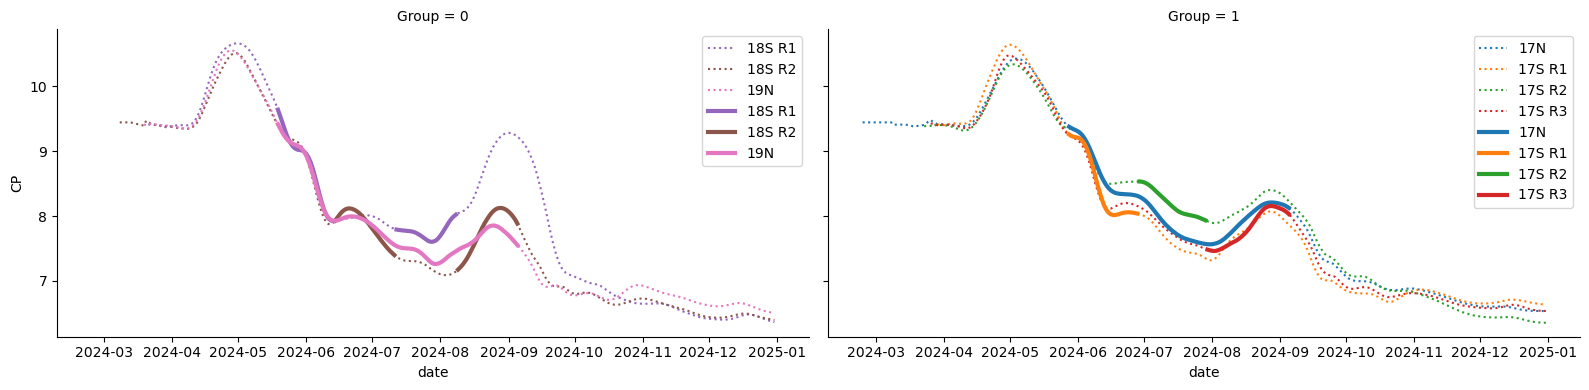

In [29]:
g = sns.FacetGrid(col='Group', hue='Pasture', col_wrap=2, data=df_sub, aspect=2, height=4)
g.map_dataframe(plt.plot, 'date', 'CP_orig', linestyle='dotted')
g.map_dataframe(plt.plot, 'date', 'CP', linewidth=3)
for ax in g.axes.flatten():
    ax.legend()

In [112]:
# preview the output dataframe
df_out.Pasture.unique()

array(['17N', '17S R1', '17S R2', '17S R3', '18S R1', '18S R2', '19N'],
      dtype=object)

In [23]:
df_out = df_out.sort_values(['Pasture', 'Year', 'date'])

In [24]:
# quality control check that all pastures are present for each year
df_out.groupby('Year').apply(lambda x: len(x['Pasture'].unique()))

Year
2000    29
2001    29
2002    29
2003    29
2004    29
2005    29
2006    29
2007    29
2008    29
2009    29
2010    29
2011    29
2013    24
2014    24
2015    24
2016    24
2017    24
2018    24
2019    24
2020    24
2021    24
2022    24
2023    24
2024    24
dtype: int64

In [25]:
pasts_plot = ['19N', '15E', '5E', '10S']
months_plot = np.arange(5, 11)

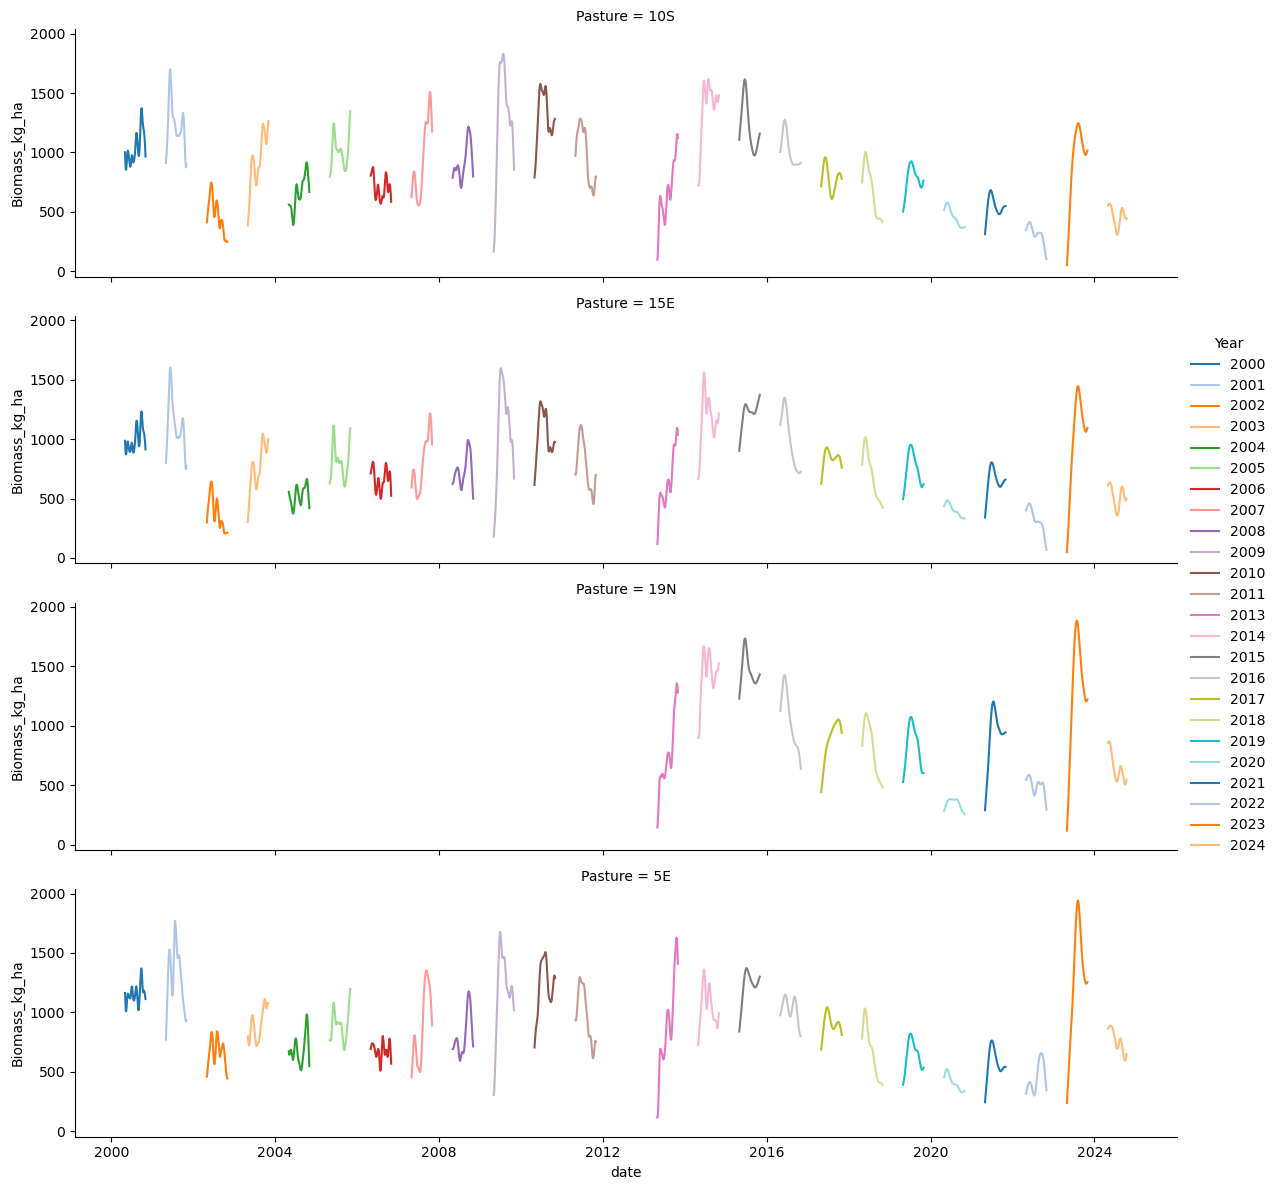

In [26]:
# plot all pastures and all dates on a single figure
sns.relplot(data=df_out[df_out['Pasture'].isin(pasts_plot) & 
            df_out['date'].dt.month.isin(months_plot)],
            x='date', y='Biomass_kg_ha', 
            row='Pasture',
            hue='Year', palette='tab20',
            kind="line", errorbar=None,
            height=3, aspect=4)

In [27]:
# write the output dataframe to disk
df_out.to_csv(out_f, index=False)

#### Plot saved results

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
# read in the saved .csv output
df_saved = pd.read_csv(out_f, parse_dates=['date'])
#df_saved

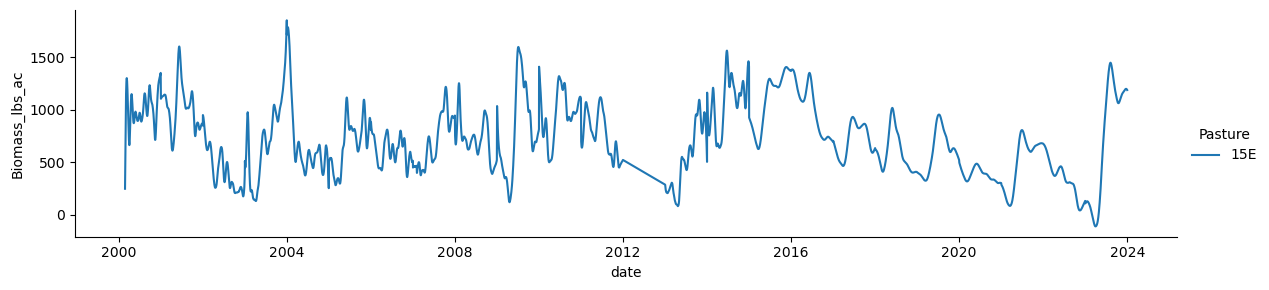

In [93]:
# plot all pastures and all dates on a single figure
sns.relplot(data=df_saved[df_saved['Pasture'] == '15E'], x='date', y='Biomass_lbs_ac', hue='Pasture', kind="line", errorbar=None,
            height=3, aspect=4)